**<h1 align="center">Text Mining Project</h1>**
**<h2 align="center">Stock Sentiment: Predicting market behavior from tweets</h2>**

project description

# Imports

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


# Loading the data

In [3]:
# Load the datasets
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

# EDA

## Data Quality

- The only values in label are 0,1 and 2
- There are no missing values on both datasets;
- There are no duplicates on both datasets;

In [5]:
df_train.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9543 entries, 0 to 9542
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9543 non-null   object
 1   label   9543 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 149.2+ KB


### Check for wrong labels

In [68]:
# Check that labels are only 0,1, or 2
df_train['label'].unique()

array([0, 1, 2])

### Check for missing values

In [9]:
# check for missing values
print("Missing values in train dataset:")
print(df_train.isnull().sum())
print("\nMissing values in test dataset:")
print(df_test.isnull().sum())

Missing values in train dataset:
text     0
label    0
dtype: int64

Missing values in test dataset:
id      0
text    0
dtype: int64


### check for duplicates

In [10]:
# check for duplicates
print("Duplicates in train dataset:", df_train.duplicated().sum())
print("Duplicates in test dataset:", df_test.duplicated().sum())

Duplicates in train dataset: 0
Duplicates in test dataset: 0


## Data Exploration

The average sentiment label in the training dataset is ~1.50, which suggests a **slight tendency toward positive or neutral sentiment**. Since the labels are categorical — Bearish (0), Bullish (1), and Neutral (2) — this average doesn’t map to a real sentiment but indicates that Bearish tweets are less frequent compared to Bullish and Neutral ones

### Label Distribution

In [54]:
label_counts = df_train['label'].value_counts().sort_index()
label_percent = round(df_train['label'].value_counts(normalize=True) * 100,1)

In [59]:
# get value counts for label
print("Label distribution in train dataset:")
print(label_counts)

# get value counts for label in percentage
print("Label distribution in train dataset (percentage):")
print(label_percent)

Label distribution in train dataset:
label
0    1442
1    1923
2    6178
Name: count, dtype: int64
Label distribution in train dataset (percentage):
label
2    64.7
1    20.2
0    15.1
Name: proportion, dtype: float64


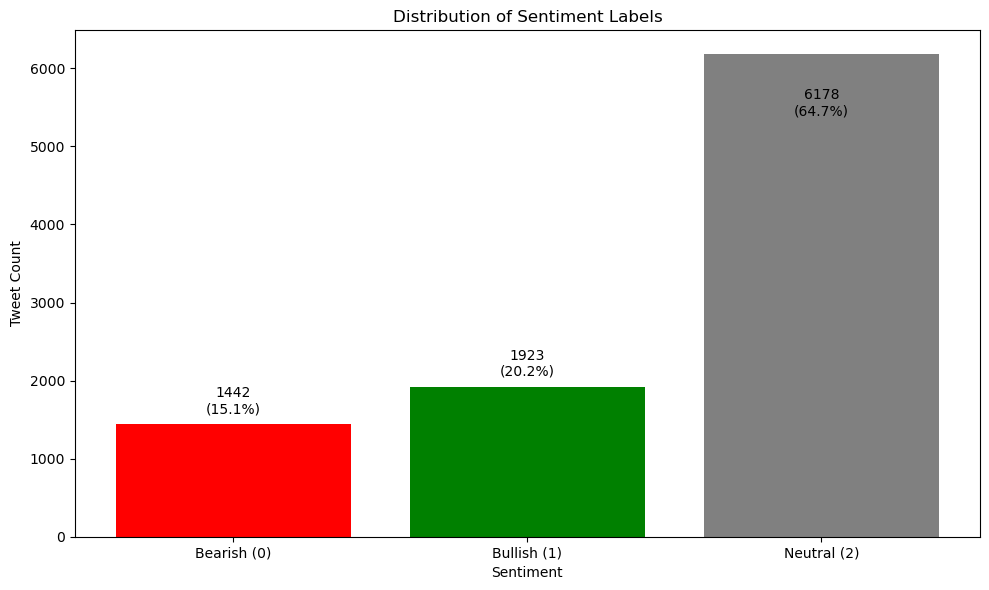

In [58]:
# Plot
colors = ['red', 'green', 'gray']
labels = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']

plt.figure(figsize=(10,6))
bars = plt.bar(labels, label_counts, color=colors)
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')

# Annotate values
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = label_percent[i]
    
    # Adjust offset depending on bar height
    offset = -0.07 * height if height > 5000 else 100
    va = 'top' if height > 5000 else 'bottom'
    
    plt.text(bar.get_x() + bar.get_width()/2,
             height + offset,
             f'{int(height)}\n({pct}%)',
             ha='center', va=va, fontsize=10, color='black')

plt.tight_layout()
plt.show()

In [62]:
# get the label mean
label_mean = df_train['label'].mean()
print(f'Our training set has a mean of {round(label_mean,1)}')

Our training set has a mean of 1.5


### Text Exploration

#### Text Length Analysis

`Key Findings` <br>

The average tweet length in the dataset is approximately 86 characters and 12 words.

Most tweets are fairly short, with 75% under 120 characters and under 15 words.

The shortest tweet has just 2 characters, and the longest reaches 190 characters or 32 words.

This confirms that the dataset fits the typical tweet format and is well-suited for models like RNNs, LSTMs, or Transformers that handle short text.

These findings will also help in setting padding/truncation parameters during preprocessing (e.g., max_len = 32 or max_len = 40 to be safe).



In [70]:
df_train['char_count'] = df_train['text'].str.len()
df_train['word_count'] = df_train['text'].str.split().apply(len)

df_train[['char_count', 'word_count']].describe()

,char_count,word_count
count,9543.000000,9543.000000
mean,85.816934,12.178351
std,35.097229,4.665599
min,2.000000,1.000000
25%,58.000000,9.000000
50%,79.000000,11.000000
75%,120.000000,15.000000
max,190.000000,32.000000


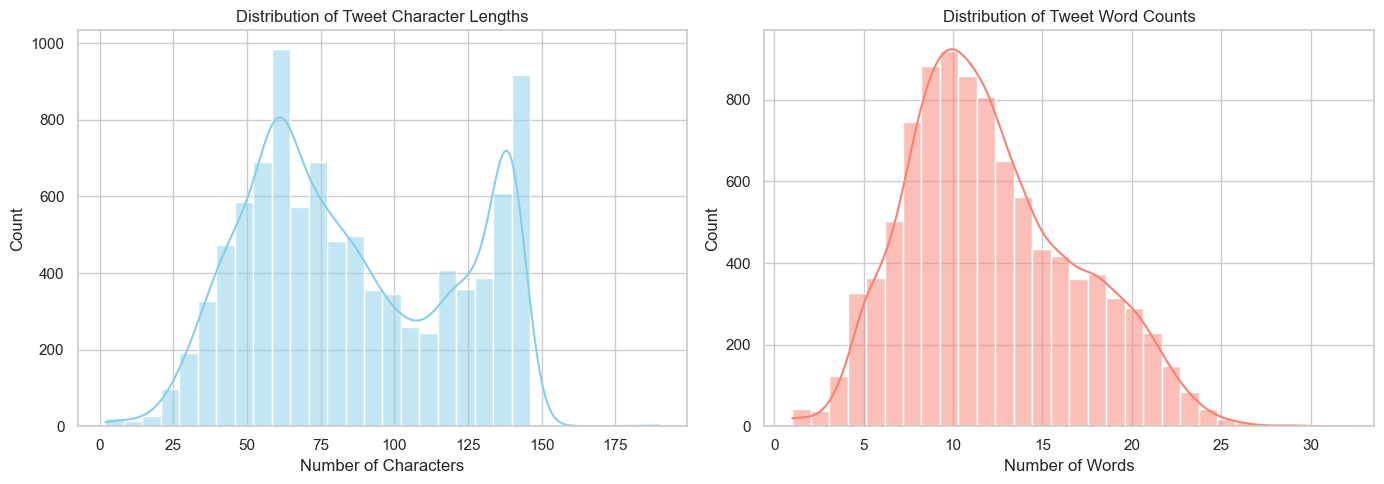

In [ ]:
# Plot histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count
sns.histplot(df_train['char_count'], bins=30, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Tweet Character Lengths')
axes[0].set_xlabel('Number of Characters')

# Word count
sns.histplot(df_train['word_count'], bins=30, ax=axes[1], color='salmon', kde=True)
axes[1].set_title('Distribution of Tweet Word Counts')
axes[1].set_xlabel('Number of Words')

plt.tight_layout()
plt.show()

#### Common Words per Sentiment Class (WordCloud)

`What the Word Clouds Reveal:` <br>

- Bearish Tweets often contain negatively charged words such as **cut, misses, lower, decline, and crisis-related terms like coronavirus, oil, and China**. This suggests a focus on economic threats, losses, and negative forecasts.

- Bullish Tweets are characterized by positive performance indicators such as **beat, rise, gain, target raised, and higher**. Words like buy and soar indicate strong investor confidence.

- Neutral Tweets tend to include objective and informative language, e.g., **update, conference call, results, CEO, dividend, MarketScreener**. These tweets appear more factual and less emotionally driven.


> The repeated appearance of noise tokens like **https, co, and rt** in all classes confirms the need for text cleaning before model training.



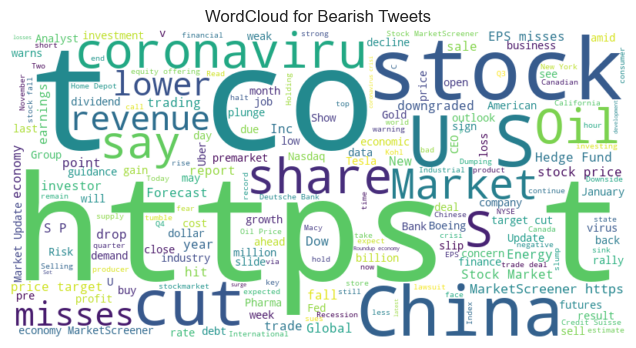

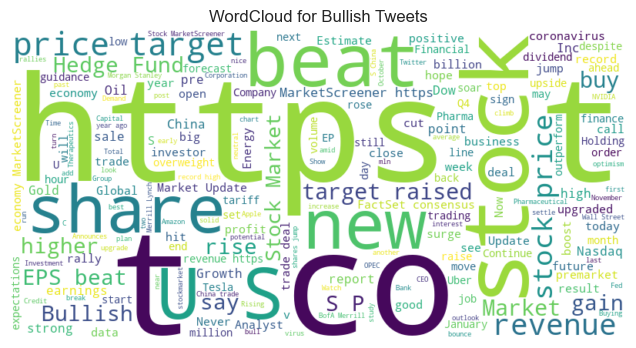

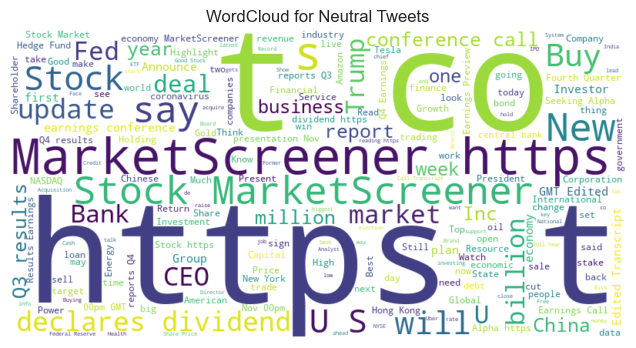

In [ ]:
for label, name in zip([0, 1, 2], ['Bearish', 'Bullish', 'Neutral']):
    text = ' '.join(df_train[df_train['label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {name} Tweets')
    plt.show()

#### Top N-grams

By extracting the most frequent bigrams (2-word sequences) in the dataset, we identify recurring phrase patterns that reflect both the contextual structure of financial tweets and potential informative features for classification.

**A large portion of frequent bigrams are news-source references**, such as:

marketscreener https; <br>
stock marketscreener;<br>
economy marketscreener;<br>
stock https.

These likely come from automatic link-sharing tweets or syndicated content.

**Other bigrams are domain-specific and sentiment-relevant**, such as:

hedge funds;<br>
price target;<br>
stock market;<br>
stock price<br>
q3 results;<br>
earnings conference;

which are informative but likely neutral in tone.

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df_train['text'])
sum_words = X.sum(axis=0)

# Most common bigrams
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:10]

for word, freq in words_freq:
    print(f"{word}: {freq}")

marketscreener https: 478
stock marketscreener: 315
hedge funds: 163
price target: 141
stock market: 137
economy marketscreener: 137
stock price: 109
q3 results: 99
earnings conference: 90
stock https: 89


# Corpus split

To prepare the dataset for model training and validation, we performed an 80/20 split on the labeled data. This means that **80% of the tweets were used for training, while 20% were held out for validation purposes**. <br>
**The split was done using stratified sampling** to ensure that the distribution of sentiment labels (Bearish, Bullish, and Neutral) remained consistent across both sets. This is **important for preventing class imbalance issues** during training and evaluation. <br>
We did not create a separate test set since a dedicated, unlabeled test dataset was already provided as part of the project. 

In [84]:
train_df, val_df = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['label'],
    random_state=42
)

# Check class distribution
print("Training Set:\n", train_df['label'].value_counts(normalize=True))
print("\nValidation Set:\n", val_df['label'].value_counts(normalize=True))


Training Set:
 label
2    0.647367
1    0.201467
0    0.151166
Name: proportion, dtype: float64

Validation Set:
 label
2    0.647459
1    0.201676
0    0.150864
Name: proportion, dtype: float64


# Preprocessing